In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
z_dim = 100

# 데이터셋에 있는 클래스 개수
num_classes = 10

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    # 완전 연결 층을 사용해 입력을 7×7×256 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7×7×256에서 14×14×128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×128에서 14×14×64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×64에서 28×28×1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수
    # 이거 이유 생각남 -> 생성자의 출력이 판별자의 입력으로 가야하는데 판별자가 ~1 ~ 1의 수를 받았었음
    model.add(Activation('tanh')) 

    return model

In [ ]:
def build_cgan_generator(z_dim):

    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, )) # 함수형일 때만 Input을 만듬 -> 입력을 두 개를 합쳐서 넣을 거니 함수형을 썼다.

    # 조건 레이블: 정수 0-9까지 생성자가 만들 숫자
    label = Input(shape=(1, ), dtype='int32') # 1 by 1짜리


    # 레이블 임베딩: 
    # ----------------
    # 레이블을 z_dim 크기 밀집 벡터로 변환하고 
    # (batch_size, 1, z_dim) 크기 3D 텐서를 만든다.


    # 1. 나에게 들어올 수 있는 단어의 종류 개수 : 클래스 10개
    # 2. 레이블을 길이가 몇 인 이진 벡터로 바꿀 거냐 : 레이블을 z와 같은 길이로 바꾼다고 했음
    # 3. 입력은 레이블 크기 1(=정수 하나)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, z_dim) 크기 2D 텐서로 바꾼다.
    label_embedding = Flatten()(label_embedding)

    # 벡터 z와 레이블 임베딩의 원소별 곱셈
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # 주어진 레이블에 대한 이미지 생성
    conditioned_img = generator(joined_representation) 

    return Model([z, label], conditioned_img)

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28×28×2에서 14×14×64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1), # 28 * 28 * 1+1
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14×14×64에서 7×7×64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7×7×64에서 3×3×128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 시그모이드 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def build_cgan_discriminator(img_shape):

    # 입력 이미지
    img = Input(shape=img_shape)

    # 입력 이미지의 레이블
    label = Input(shape=(1, ), dtype='int32')

    # 레이블 임베딩: 
    # ----------------
    # 레이블을 z_dim 크기의 밀집 벡터로 변환하고 
    # (batch_size, 1, 28×28×1) 크기의 3D 텐서를 만든다.


    # 1. 나에게 들어올 수 있는 단어의 종류 개수 : 클래스 10개
    # 2. 레이블을 길이가 몇 인 이진 벡터로 바꿀 거냐 : 레이블을 z와 같은 길이로 바꾼다고 했음
    # 3. 입력은 레이블 크기 1
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape), # np.prod = 내부 요소들의 곱
                                input_length=1)(label)

    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, 28×28×1) 크기의 2D 텐서를 만든다.
    label_embedding = Flatten()(label_embedding)

    # 레이블 임베딩 크기를 입력 이미지 차원과 동일하게 만든다.
    label_embedding = Reshape(img_shape)(label_embedding)

    # 이미지와 레이블 임베딩을 연결
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    # 이미지-레이블 쌍을 분류
    classification = discriminator(concatenated)

    return Model([img, label], classification) # start가 이 두개, end가 classify

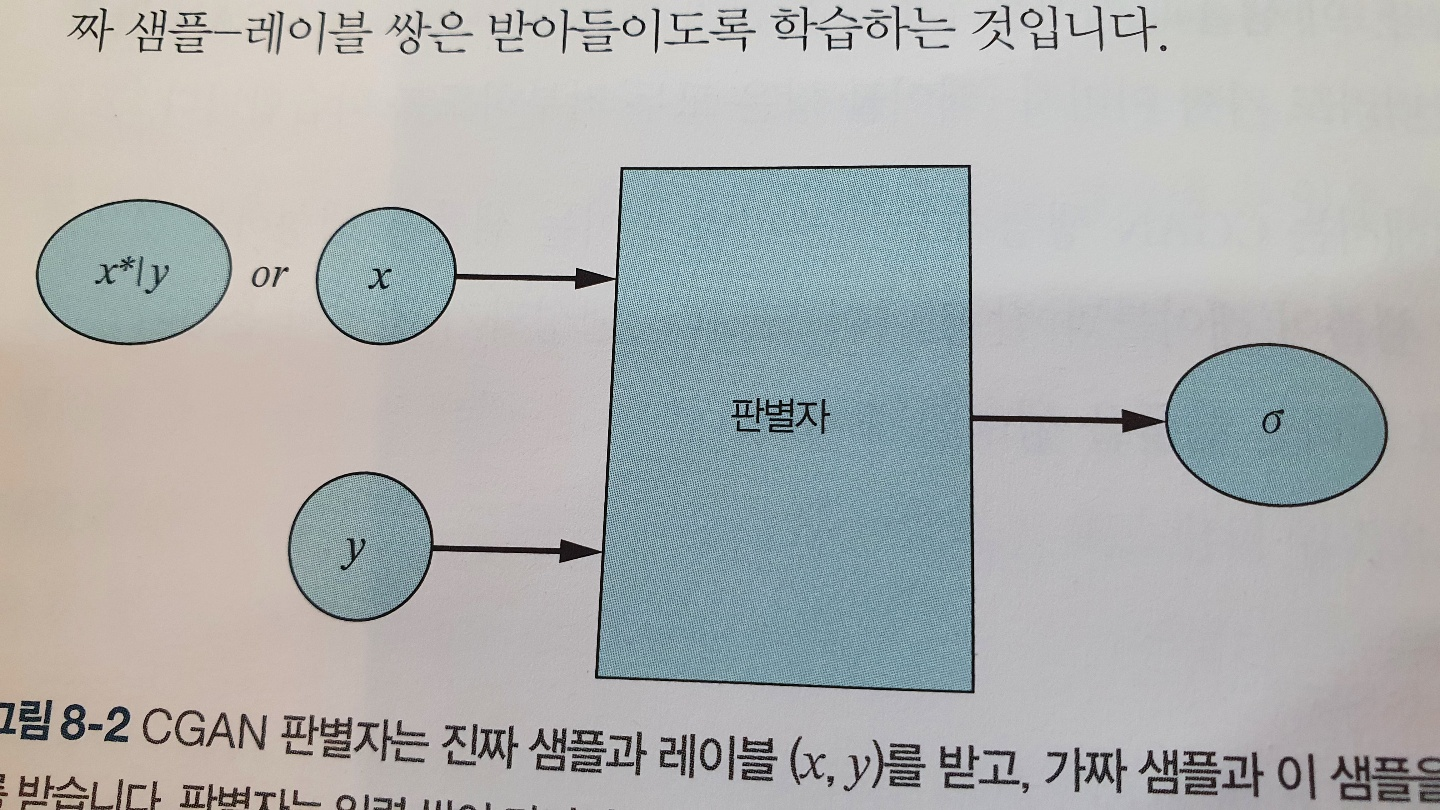

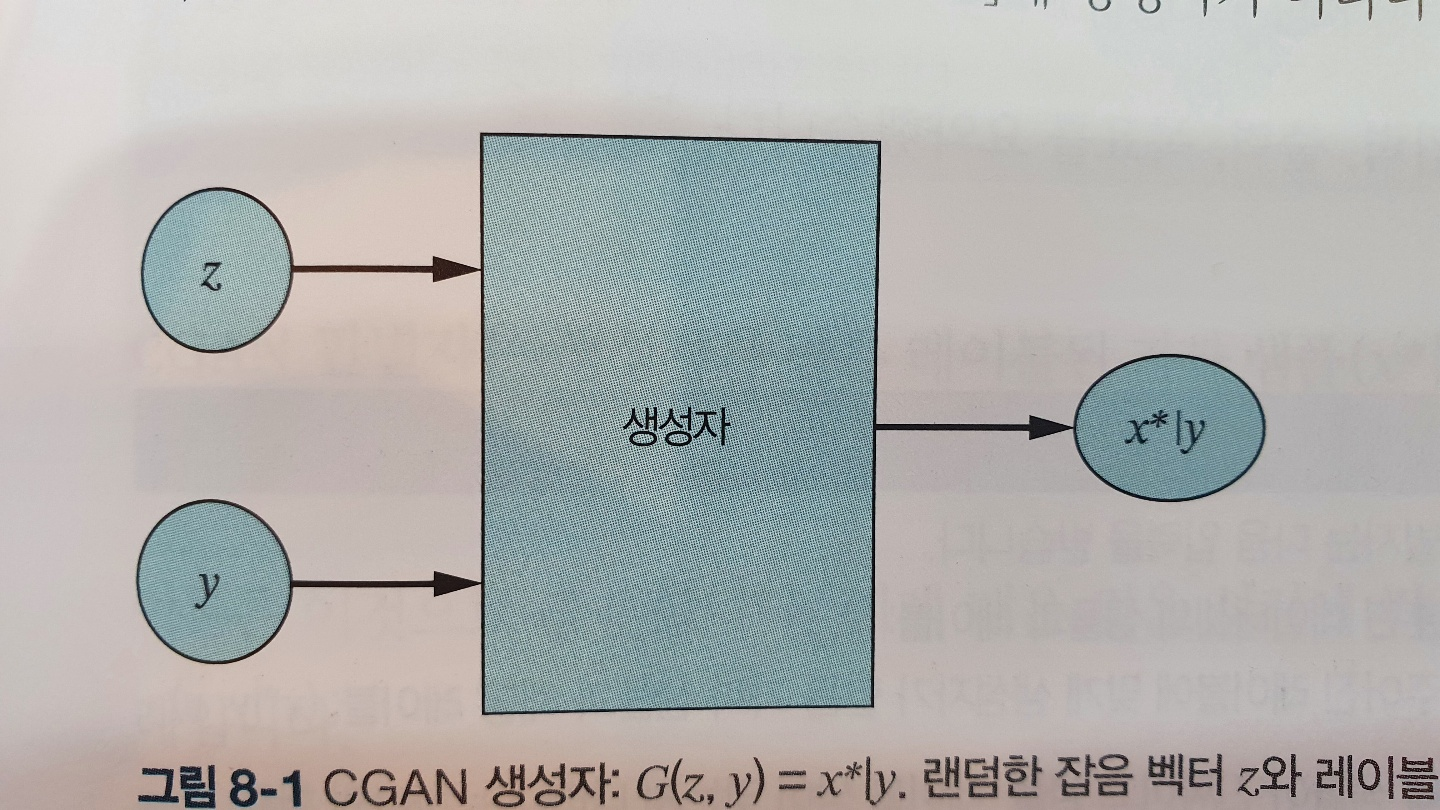

In [ ]:
# 이게 3장 코드와 다른 건 함수형이고 z, label 등등이 생겼기 때문
def build_cgan(generator, discriminator):

    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))

    # 이미지 레이블
    label = Input(shape=(1, ))

    # 레이블에 맞는 이미지 생성하기
    img = generator([z, label])

    classification = discriminator([img, label]) # 위 이미지처럼 판별자와 생성자에 인자를 넣음

    # 생성자 -> 판별자 연결 모델 
    # G([z, label]) = x* 
    # D(x*) = 분류
    model = Model([z, label], classification)

    return model

```
놀랍게도 모델 생성은 3장 코드와 똑같다.
```


In [ ]:
# 판별자 만들고 컴파일하기
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

# 생성자 만들기
generator = build_cgan_generator(z_dim)

# 생성자를 훈련하는 동안 판별자 모델 파라미터를 고정하기
discriminator.trainable = False

# 생성자를 훈련하기 위해 고정된 판별자로 CGAN 모델 만들고 컴파일하기
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋을 로드합니다.
    (X_train, y_train), (_, _) = mnist.load_data()

    # [0, 255] 사이 흑백 픽셀 값을 [–1, 1]로 스케일 변환
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지의 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지의 레이블: 모두 0
    fake = np.zeros((batch_size, 1))


    for iteration in range(iterations):

        #  판별자를 훈련합니다.
        # 진짜 이미지와 레이블로 이루어진 랜덤한 배치를 얻음
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0, 60000만 사이 숫자 batch_size 개수 만큼 랜덤 생성
        imgs, labels = X_train[idx], y_train[idx] 

        # 가짜 이미지 배치를 생성
        z = np.random.normal(0, 1, (batch_size, z_dim)) # 평균 0, 표편 1, 사이즈
        gen_imgs = generator.predict([z, labels]) # 랜덤 z로 가짜 이미지 32개 생성

        # 판별자를 훈련
        d_loss_real = discriminator.train_on_batch([imgs, labels], real) # 진짜를 진짜라고 말하고
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake) # 가짜를 가짜라고 말한다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 



        #  생성자를 훈련합니다.
        # 잡음 벡터의 배치를 생성
        z = np.random.normal(0, 1, (batch_size, z_dim)) # 랜덤 잡음 벡터 32 by 100 32개 만듬

        # 0 ~ 9 가짜 레이블 32개 만들고 
        # reshape -1로 1열 32행 만듬 
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1) 

        # 생성자를 훈련
        g_loss = cgan.train_on_batch([z, labels], real)



        if (iteration + 1) % sample_interval == 0:

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도를 저장
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # 생성한 이미지 샘플을 출력
            sample_images()

In [ ]:
# 하이퍼파라미터를 설정
iterations = 20000
batch_size = 32
sample_interval = 1000

# 지정된 반복 횟수 동안 CGAN을 훈련
train(iterations, batch_size, sample_interval)

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.694055, acc.: 39.06%] [G loss: 0.673646]
2000 [D loss: 0.713752, acc.: 35.94%] [G loss: 0.641704]
3000 [D loss: 0.689979, acc.: 48.44%] [G loss: 0.643226]
4000 [D loss: 0.705431, acc.: 17.19%] [G loss: 0.684621]
5000 [D loss: 0.709466, acc.: 37.50%] [G loss: 0.646511]
6000 [D loss: 0.678713, acc.: 92.19%] [G loss: 0.707700]
7000 [D loss: 0.687026, acc.: 43.75%] [G loss: 0.673554]
8000 [D loss: 0.671679, acc.: 50.00%] [G loss: 0.645408]
9000 [D loss: 0.703222, acc.: 46.88%] [G loss: 0.641007]
10000 [D loss: 0.684143, acc.: 56.25%] [G loss: 0.742382]
11000 [D loss: 0.688240, acc.: 50.00%] [G loss: 0.624431]
12000 [D loss: 0.702137, acc.: 29.69%] [G loss: 0.668363]
13000 [D loss: 0.669528, acc.: 53.12%] [G loss: 0.657829]
14000 [D loss: 0.630592, acc.: 85.94%] [G loss: 0.765890]
15000 [D loss: 0.672753, acc.: 68.75%] [G loss: 0.683702]
16000 [D loss: 0.657404, acc.: 70.31%] [G loss: 0.737722]
17000 [D loss: 0

In [ ]:
generator.save("cgan_generator.h5")

## ★★★테스트★★★

-> 생성자에는 z를 넣어 다양한 데이터를 생성하는지 테스트 해야한다.

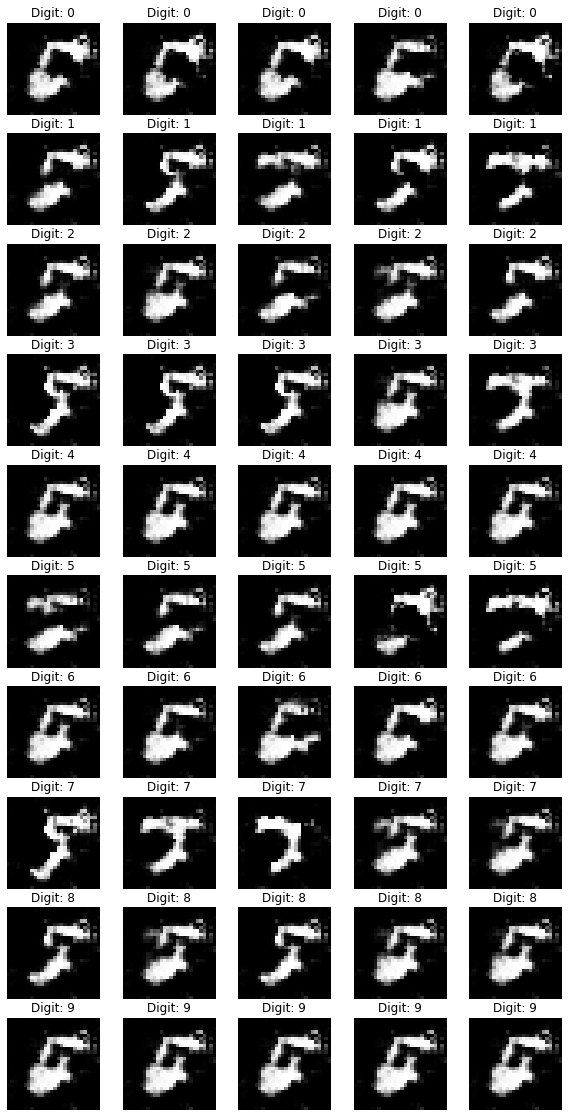

In [ ]:
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음을 샘플링
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # 이미지 그리드를 출력
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model("/content/cgan_generator.h5")

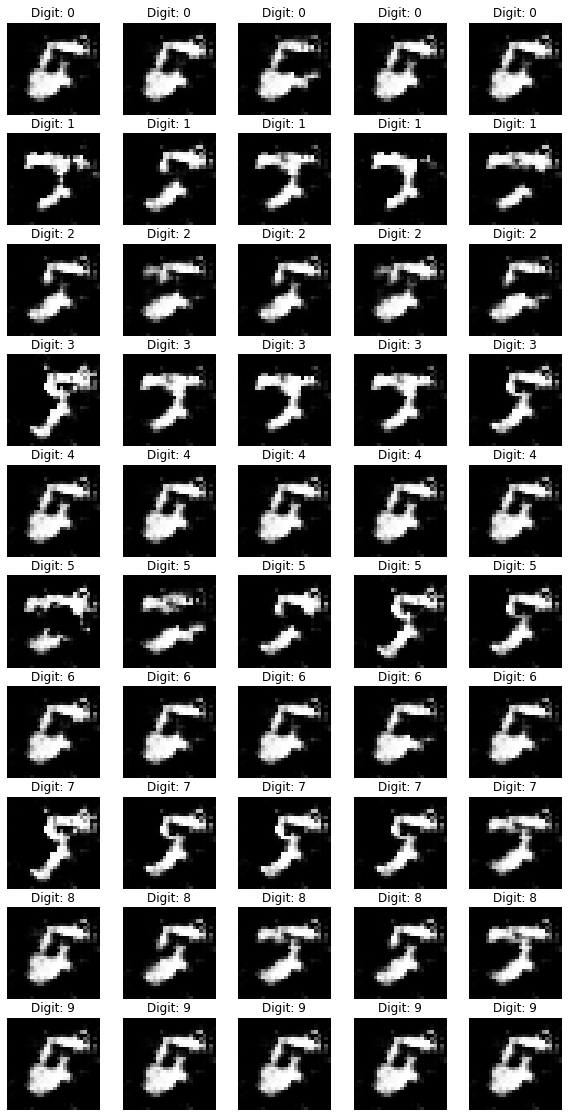

In [ ]:
# 그리드 차원을 설정합니다.
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음을 샘플링합니다.
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비합니다.
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성합니다.
gen_imgs = model.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정합니다.
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # 이미지 그리드를 출력합니다.
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1